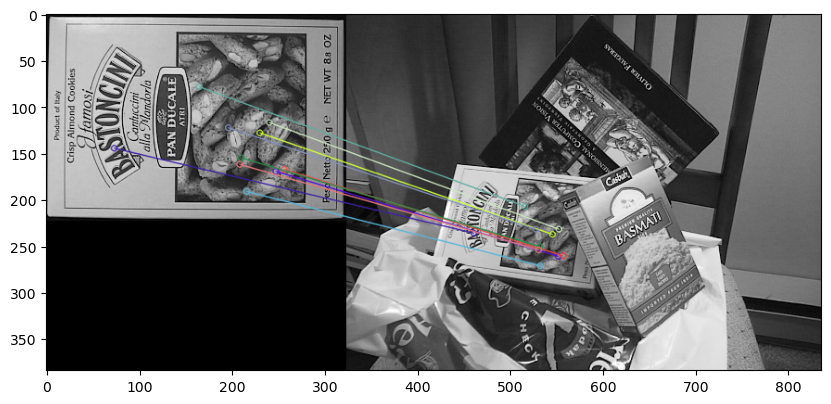

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

qureyImg = cv.imread('box.png', cv.IMREAD_GRAYSCALE)
trainImg = cv.imread('box_in_scene.png', cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create()

query_keypoints, query_desc = sift.detectAndCompute(qureyImg, None)
train_keypoints, train_desc = sift.detectAndCompute(trainImg, None)

FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.match(query_desc, train_desc)

matches = sorted(matches, key = lambda x:x.distance)

res = cv.drawMatches(qureyImg, query_keypoints, trainImg, train_keypoints, \
                    matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10,10))
plt.imshow(res)

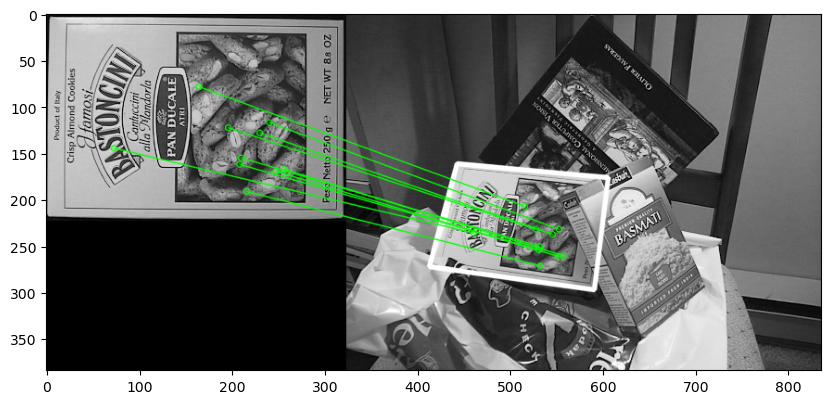

In [2]:
import numpy as np

good = matches[:10]
src_pts = np.float32([ query_keypoints[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ train_keypoints[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

matchesMask = mask.ravel().tolist()

h,w = qureyImg.shape

rect_pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
rect_dst = cv.perspectiveTransform(rect_pts, M)
rect_dst = np.int32(rect_dst)

res = cv.polylines(trainImg, [rect_dst], True, 255, 3, cv.LINE_AA)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

res = cv.drawMatches(qureyImg, query_keypoints, res, train_keypoints, \
                    good, None, **draw_params)

plt.figure(figsize=(10,10))
plt.imshow(res)
